In [240]:
# Load modules
import hddm
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
import psutil
from time import time
from copy import deepcopy
import os
import pickle
import argparse
import yaml as yml
from multiprocessing import Pool
from functools import partial
from scipy.stats.stats import pearsonr


In [244]:
def choice_percentage_check(data = None,
                            perc_cutoff = 0.05,
                            response_options = [0, 1]):

    for resp in response_options:
        if np.sum(data.response == resp) < int(data.shape[0] * perc_cutoff):
            #print(np.sum(data.response == resp) / data.shape[0])
            return 0
        else:
            #print(np.sum(data.response == resp) / data.shape[0])
            pass
    return 1

def param_buffer_check(theta = None,
                       buffer_perc = 0.1):
    for param in model_config['ddm']['params']:
        tmp_idx = model_config['ddm']['params'].index(param)

        a = model_config['ddm']['param_bounds'][0][tmp_idx]
        b = model_config['ddm']['param_bounds'][1][tmp_idx]

        tmp_dist = b - a
        tmp_dist_proposed = param_sets[param].values[0] - a

        if (tmp_dist_proposed < 0.1 * (tmp_dist)) or (tmp_dist_proposed > 0.9 * (tmp_dist)):
            return 0
    return 1

def added_checks(theta = None,
                 check_dictionary = {'equal': {},
                                     'higher': {'v': -5},
                                     'lower': {'v': 5}}):
    for key_test_type_ in check_dictionary.keys():
        if check_dictionary[key_test_type_] is not None:
            for key_ in check_dictionary[key_test_type_]:
                if key_test_type_ == 'equal':
                    if theta[key_].values[0] != check_dictionary[key_test_type_][key_]:
                        return 0
                    
                elif key_test_type_ == 'higher':
                    if theta[key_].values[0] < check_dictionary[key_test_type_][key_]:
                        return 0

                elif key_test_type_ == 'lower':
                    if theta[key_].values[0] > check_dictionary[key_test_type_][key_]:
                        return 0
    return 1

In [ ]:
def make_ground_truth_dataset(model = 'ddm',
                              n_datasets = 50,
                              p_outlier = 0.0,
                              buffer_perc = 0.1,
                              choice_percentage_cutoff = 0.05,
                              added_check_dictionary = {'lower': {'v': 10}}, # 'lower', 'equal', 'higher'
                              response_coding = 'hddm',
                              save = True,
                              save_folder = 'data/parameter_recovery'
                              ):

    if response_coding == 'hddm':
        response_options = [0, 1]

    assert response_coding == 'hddm', 'Response coding needs to be set to hddm at this point. No alternatives allowed!'
    
    param_list = hddm.model_config.model_config[model]['params']
    data_dict = {}
    cnt = 0
    simple_cnt = 0

    while cnt < n_datasets:
        param_df = hddm.simulators.make_parameter_vectors_nn(model = model,
                                                            n_parameter_vectors = 1)
        
        model_data = hddm.simulators.simulator_single_subject(model = model,
                                                              parameters = param_df.loc[0, :][param_list].values, 
                                                              p_outlier = p_outlier,
                                                              n_samples = 1000)
        
        cp_check_ = choice_percentage_check(data = model_data[0], perc_cutoff = choice_percentage_cutoff, response_options = response_options)
        buffer_check_ = param_buffer_check(theta = param_df,
                                        buffer_perc = buffer_perc)
        added_checks_ = added_checks(theta = param_df,
                                     check_dictionary = added_check_dictionary)
        
        if cp_check_ and buffer_check_ and added_checks_:
            data_dict[cnt] = {}
            data_dict[cnt]['dataset'] = model_data[0]
            data_dict[cnt]['dataset']['subj_idx'] = cnt
            data_dict[cnt]['param_dict'] = model_data[1]
            cnt += 1
            #print(cnt)
        else:
            #print('defective dataset')
            pass
        simple_cnt += 1

        if simple_cnt % 10 == 0:
            print(simple_cnt)

    if save:
        pickle.dump(data_dict, open(save_folder + '/param_recov_dataset_' + model + '.pickle', 'wb'))

In [236]:
def load_inference_df(folder = 'hddm_models',
                        model = 'ddm',
                        tag = ['navarro', 'df']):

    folder_ = folder + '/' + model
    files_ = os.listdir(folder_)
    tags = tag

    param_recov_list = []
    for file_ in files_:
        load_ok = 1
        for tag_ in tags:
            if not (tag_ in file_):
                load_ok = 0
        
        if load_ok:
            print('passed')
            my_dat = pickle.load(open(folder_ + '/' + file_, 'rb'))
            tmp = pd.DataFrame(dict(my_dat.loc[0, ['traces']][0].drop(labels = ['deviance', 'z_trans'], axis = 1).mean()), index = [my_dat.subj_idx.values[0]])
            tmp['subj_idx'] = my_dat.subj_idx.values[0]
            param_recov_list.append(pd.DataFrame(tmp))

    param_recov_df = pd.concat(param_recov_list).sort_values('subj_idx').reset_index(drop = True)
    return param_recov_df

In [187]:
def load_gt_df(dataset_folder = 'data/',
              model = 'ddm'):
    
    gt_data = pickle.load(open(dataset_folder + '/' + 'param_recov_dataset_' + model + '.pickle', 'rb'))
    recov_list = []
    
    for key_ in gt_data.keys():
        tmp = pd.DataFrame(gt_data[key_]['param_dict'], index = [key_])
        tmp['subj_idx'] = key_
        recov_list.append(tmp)

    gt_df = pd.concat(recov_list)

    return gt_df

In [ ]:
def check_subj_in_intersection(x, **kwargs):
    if x['subj_idx'] in kwargs['subj_list']:
        return 1
    else:
        return 0

In [226]:
# ANGLE LAN / NAVARRO
lan_angle_param_recov_df = load_model_data(folder = 'hddm_models',
                                           model = 'angle',
                                           tag = ['lan', 'df'])
navarro_angle_param_recov_df = load_model_data(folder = 'hddm_models',
                                               model = 'angle',
                                               tag = ['navarro', 'df'])

# Legal subj list:
legal_subj_list = list(set(lan_angle_param_recov_df.subj_idx.unique()).intersection(set(navarro_angle_param_recov_df.subj_idx.unique())))

lan_angle_param_recov_df['legal'] = lan_angle_param_recov_df.apply(check_subj_in_intersection, axis = 1, raw=False, **{'subj_list': legal_subj_list})
navarro_angle_param_recov_df['legal'] = lan_angle_param_recov_df.apply(check_subj_in_intersection, axis = 1, raw=False, **{'subj_list': legal_subj_list})

lan_angle_param_recov_df = lan_angle_param_recov_df[lan_angle_param_recov_df.legal == 1].sort_values('subj_idx').reset_index(drop = True)
navarro_angle_param_recov_df = navarro_angle_param_recov_df[navarro_angle_param_recov_df.legal == 1].sort_values('subj_idx').reset_index(drop = True)

passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed

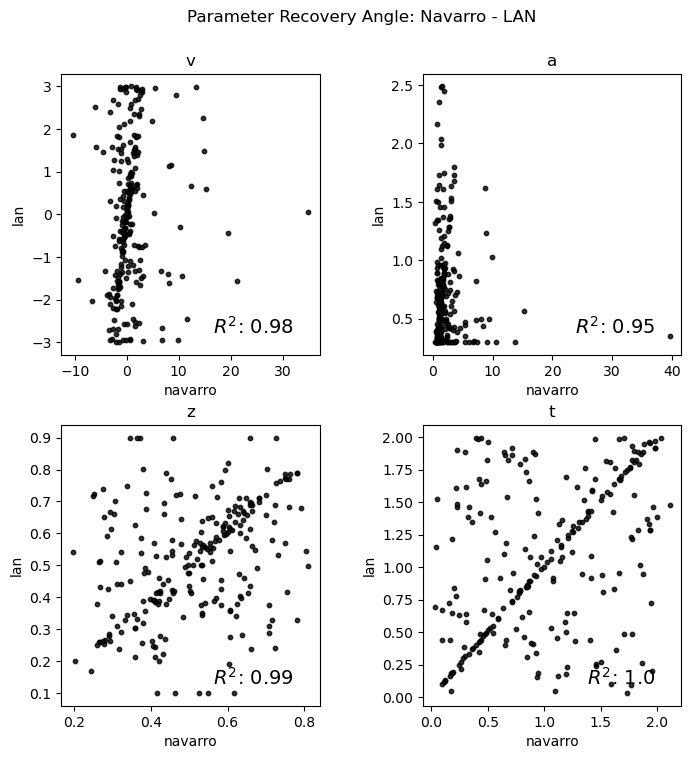

In [227]:
parameter_recovery_plot(x_data = navarro_angle_param_recov_df,
                        y_data = lan_angle_param_recov_df,
                        title = 'Parameter Recovery Angle: Navarro - LAN',
                        save = True,
                        x_label  = 'navarro',
                        y_label  = 'lan')

In [188]:
def  parameter_recovery_plot(x_data = None,
                             y_data = None,
                             params = ['v', 'a', 'z', 't'],
                             figsize = (8, 8),
                             ncols = 2,
                             title = '',
                             x_label = 'ground truth',
                             y_label = 'estimated',
                             save_name = 'parameter_recovery_plot',
                             save = False):

    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)
    fig.subplots_adjust(top=0.9, hspace=0.25, wspace=0.4)

    nrows = int(np.ceil(len(params) / ncols))
    i = 1
    for param in params:
        ax = fig.add_subplot(nrows, ncols, i)
        i += 1
        ax.scatter(x_data[param], y_data[param], color = 'black', alpha  = 0.8, s = 10)
        ax.set_title(param)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)


        r_2 = np.square(pearsonr(gt_df[param], param_recov_df[param])[0])
        ax.text(0.9, 0.1, r"$R^2$: " + str(round(r_2, 2)),
                fontsize = 14, 
                horizontalalignment = 'right', 
                verticalalignment = 'center',
                transform = ax.transAxes)
    
    if save:
        plt.savefig('figures/' + save_name + '.png')

    plt.show()
    return

In [196]:
lan_angle_param_recov_df = load_model_data(folder = 'hddm_models',
                                         model = 'angle',
                                         tag = ['lan', 'df'])
navarro_angle_param_recov_df = load_model_data(folder = 'hddm_models',
                                             model = 'angle',
                                             tag = ['navarro', 'df'])

passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed

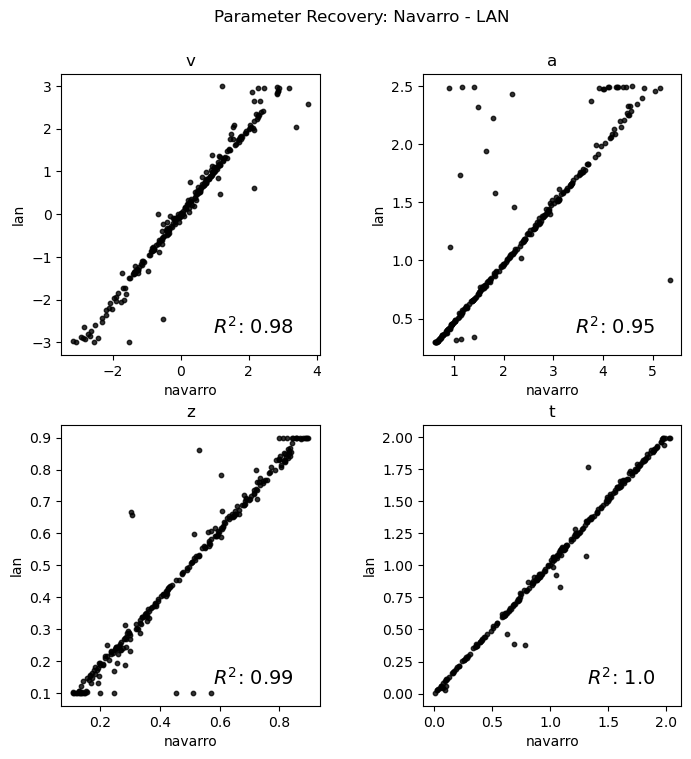

In [195]:
parameter_recovery_plot(x_data = navarro_ddm_param_recov_df,
                        y_data = lan_ddm_param_recov_df,
                        title = 'Parameter Recovery: Navarro - LAN',
                        save = True,
                        x_label  = 'navarro',
                        y_label  = 'lan')

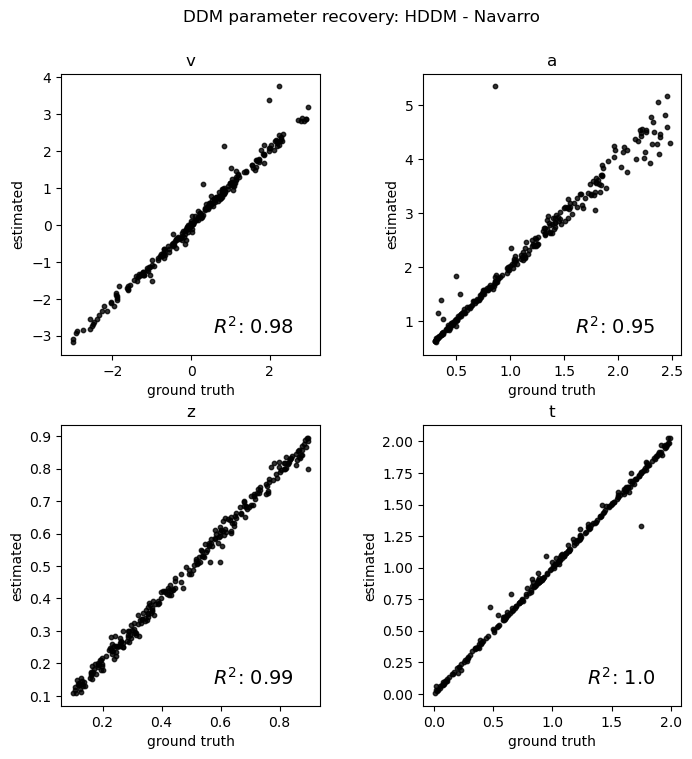

In [183]:
parameter_recovery_plot(x_data = gt_df,
                        y_data = param_recov_df,
                        title = 'DDM parameter recovery: HDDM - Navarro',
                        save = True)